In [1]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import itertools
import sys
import numpy as np
import os
import matplotlib.pyplot as plt
net = load_model("model-resnet50-final.h5")

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [2]:
import cv2
def pixelization(img):
    # Input image
    # Get input size
    height, width = img.shape[:2]

    # Desired "pixelated" size
    w, h = (32,32)

    # Resize input to "pixelated" size
    temp = cv2.resize(img, (w, h), interpolation=cv2.INTER_NEAREST)

    # Initialize output image
    output = cv2.resize(temp, (width, height), interpolation=cv2.INTER_NEAREST)
    #cv2.imshow('Input', input)
    #cv2.imshow('Output', output)
    
    #cv2.waitKey(0)
    return output

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized confusion matrix")
    else:
        print('\nConfusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def plot_graph(cnf_matrix,cls_list):
    np.set_printoptions(precision=5)


    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=cls_list,
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=cls_list, normalize=True,
                      title='Normalized confusion matrix')


{drawings} inference running...

0


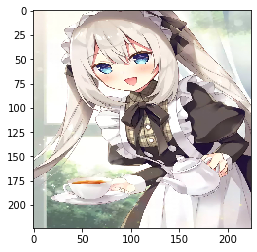

    1.000  drawings
    0.000  hentai
    0.000  neutral
    0.000  sexy
    0.000  porn

{hentai} inference running...

0


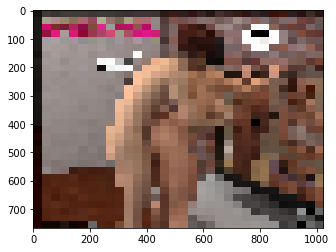

    1.000  porn
    0.000  hentai
    0.000  sexy
    0.000  drawings
    0.000  neutral

{neutral} inference running...

0


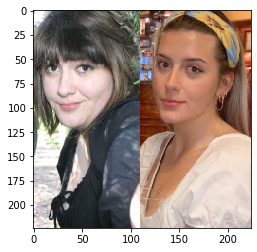

    1.000  neutral
    0.000  sexy
    0.000  drawings
    0.000  hentai
    0.000  porn

{porn} inference running...

0


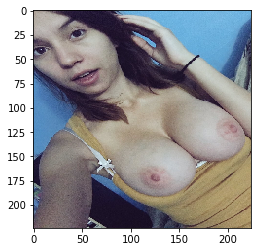

    1.000  sexy
    0.000  neutral
    0.000  hentai
    0.000  porn
    0.000  drawings

{sexy} inference running...

0


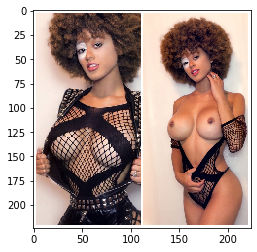

    0.573  sexy
    0.426  neutral
    0.000  porn
    0.000  hentai
    0.000  drawings


In [5]:
y_pred=[]
y_true=[]
cls_list = ['drawings','hentai','neutral','porn','sexy']

save_directory = "save_1"
if not os.path.exists(save_directory):
    os.mkdir(save_directory)
main_directory = "test"
max_inference_per_class = 100
max_display_per_class = 1
print_enable=False
# 辨識每一張圖
for j in range(len(cls_list)):
    print("\n{"+cls_list[j]+"}"+" inference running...\n")
    directory = os.path.join(main_directory, cls_list[j])
    counter=0
    d_counter=0
    for f in os.listdir(directory):
        
        join_f = os.path.join(directory, f)
        img = image.load_img(join_f, target_size=(224,224))
        cv_image = cv2.imread(join_f)

        if img is None:
            continue
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis = 0)
        pred = net.predict(x)
        pred_argmax = pred.argmax()
        if pred_argmax==1 or pred_argmax==3:
            new_img = pixelization(cv_image)
        else:
            new_img = cv_image
            
        save_path = os.path.join(save_directory, cls_list[j])
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        photo_path = os.path.join(save_path, f)
        
        cv2.imwrite(photo_path,new_img)

            
        if counter%100==0:
            print(counter)
        if print_enable:
            print('{:<120}'.format(f),end='\t')
        if d_counter<max_display_per_class:
            if pred_argmax==1 or pred_argmax==3:
                new_img = pixelization(cv_image)
                new_img2 = new_img[:,:,::-1]
                imgplot = plt.imshow(new_img2)
                plt.show()    
            else:
                imgplot = plt.imshow(img)
                plt.show()                        
            top_inds = pred[0].argsort()[::-1][:5]
            for i in top_inds:
                print('    {:.3f}  {}'.format(pred[0][i], cls_list[i]))
        else:
            if print_enable:
                print('{:>16}'.format("Result: ")+cls_list[pred_argmax])
        y_pred.append(pred_argmax)
        y_true.append(j)
        counter+=1
        d_counter+=1
        if counter>=max_inference_per_class:
            counter=0
            d_counter=0
            break
    
cnf_matrix = confusion_matrix(y_true, y_pred)


Confusion matrix, without normalization
[[85  8  7  0  0]
 [14 81  3  1  1]
 [ 3  0 87  3  7]
 [ 0  2  7 86  5]
 [ 2  2 12  4 80]]

Normalized confusion matrix
[[0.85 0.08 0.07 0.   0.  ]
 [0.14 0.81 0.03 0.01 0.01]
 [0.03 0.   0.87 0.03 0.07]
 [0.   0.02 0.07 0.86 0.05]
 [0.02 0.02 0.12 0.04 0.8 ]]


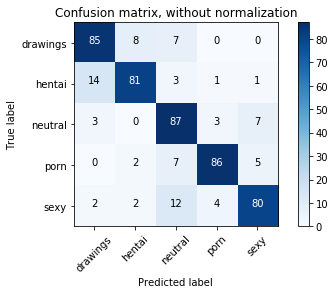

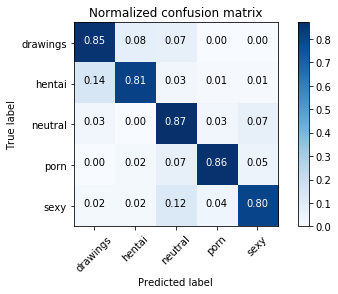

In [6]:
plot_graph(cnf_matrix,cls_list)